# Part 2

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request
import datetime as dt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
from pylab import * 

In [3]:
def generate_data(m,n,winnow=False):
    """
    Given a combination of m and n, it generates a random data matrix X of dimensions (m x (n+1)).
    Each cell of this matrix will randomly be either -1 or 1.
    It also computes a corresponding X matrix of size (m x 1), which is the first column of X.
    :param m: the number of rows.
    :param n: the number of columns
    :param winnow: if this flag is set to true, cell values will be in the {0, 1} set instead of {-1, 1}
    :return: the generated x and y matrices
    """
    if winnow:
        data = np.random.randint(2, size=(m,(n+1)))
        data = np.sign(data)
    else:
        data = np.random.uniform(low=-1, high=1, size=(m,(n+1)))
        data = np.sign(data)
    x = data
    y = data[:,0]
    return x,y

def add_bias(x):
    """
    Transforms x by adding an extra column of "1", i.e. bias.
    :param x: a matrix of m examples and n columns
    :return: the transformed matrix x_with_bias, of m examples and n+1 columns
    """
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

## Binary Perceptron

In [4]:
def perceptron_train(x, y, max_epoch=20, tol=0.01, learning_rate=1, random_select=False, eta=0.001):
    """
    It trains a perceptron classifier over multiple epochs.
    :param x: a matrix of observations
    :param y: the corresponding labels
    :param max_epoch: the maximum epochs to perform over the data
    :param tol: a tolerance value, used as a convergence criterion for the error rate.
    :param learning_rate: the learning rate parameter of the perceptron
    :param random_select: whether or not to select a random number of times to train the perceptron
    :param eta: used as a threshold value to determine when to update weights
    :return: a set of weights W and the errors made in the last iteration
    """
    m_train = x.shape[0]  # number of examples
    n = x.shape[1]  # number of features
    x = add_bias(x)
    error_per_epoch = np.zeros(max_epoch)
    W = np.zeros(n + 1)
    R = np.sqrt(n + 1)  # max norm
    error_bound = (R / eta) ** 2  # maximum number of mistakes it makes before convergence.

    if random_select:
        max_epoch = 1
        m = np.random.randint(low=0, high=m_train)  # select random number of times to train the perceptron.
    else:
        m = m_train

    for epoch in range(max_epoch):
        errors = np.zeros(m)
        num_errors = 0  # This should be bounded..? Maybe calculate the bound in the explanation

        # iterate through training set
        for t in range(m):
            x_t = x[t, :]
            y_t = y[t]
            pred_t = W @ x_t

            if pred_t * y_t < eta:
                num_errors += 1
                W = W + learning_rate * x_t.T * y_t
                errors[t] = num_errors
                if num_errors >= error_bound:
                    break

        error_per_epoch[epoch] = num_errors

        if epoch > 1:
            diff_rates = (error_per_epoch[epoch - 1] - error_per_epoch[epoch]) / m

            # Stop if the error rate has increased,
            # or the difference in error rate between the previous one and the current one < tolerance.
            if error_per_epoch[epoch] / m < 0.05:
                print('error rate< 10%')
                if diff_rates < tol:
                    print('converging')
                    break
                elif diff_rates < 0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch] == 0:
                    print('no error')
                    break

    return W, error_per_epoch[:epoch + 1]

def perceptron_test(x_test,y_test,W):
    """
    Given a set of weights W, it calculates the perceptron predictions over an unlabelled set of data x_test 
    as well as the number of mistakes.
    :param x_test: an unlabelled set of data observations
    :param y_test: their corresponding labels
    :param W: the perceptron's wegight
    :return: the number of mistakes and the predictions over x_test
    """
    x_test = add_bias(x_test)
    pred = np.sign(x_test @ W)  # (n,1) x (m_test,n)
    diff = pred - y_test
    mistakes = len(diff[diff != 0])
    return mistakes, pred

In [185]:
x,y = generate_data(20,30)
W, error_per_epoch = perceptron_train(x,y,max_epoch=30, tol=0.01, learning_rate=1)

error rate< 10%
no error


In [5]:
mistakes,pred = perceptron_test(x[:10],y[:10],W)

In [6]:
error_per_epoch
### Does not seem to converge for some combination of x and y. 

array([8., 3., 2., 0.])

## Winnow

In [6]:
def winnow_train(x,y,max_epoch=20,tol=0.01, learning_rate=1):
    """
    Trains a winnow classifier over a set of observations x and their corresponding labels y
    :param x: a matrix of observations 
    :param y: their corresponding labels
    :param max_epoch: the maximum number of epochs to perform over the data
    :param tol: a tolerance value, used as a convergence criterion for error rate
    :param learning_rate: the learning rate of the classifier
    :return: the vector of weights W, and the number of mistakes made in the last iteration
    """
    m = x.shape[0]
    n = x.shape[1]
    error_per_epoch = np.zeros(max_epoch)
    W = np.ones(n + 1)
    x = add_bias(x)
    gamma_bound = n / 2

    epoch = 0
    while epoch < max_epoch:
        errors = np.zeros(m)
        num_errors = 0  # This should be bounded..? Maybe calculate the bound in the explanation
        # iterate through training set
        for t in range(m):
            x_t = x[t, :]
            y_t = y[t]
            gamma = W @ x_t

            if gamma >= gamma_bound:
                pred_t = 1
            else:
                pred_t = 0

            if pred_t != y_t:
                num_errors += 1
                power = (y_t - pred_t) * x_t / 1.0  # 1 when error made on positive class, -1 when error made on negative class
                W = W * (2 ** power)  # element wise multiplication, and element wise power
                # Once weight>n, it should no longer change.
                W[W > n] = n
                errors[t] = num_errors

        error_per_epoch[epoch] = num_errors

        if epoch > 1:
            diff_rates = (error_per_epoch[epoch - 1] - error_per_epoch[epoch]) / m
            # Stop if the error rate has increased,
            # or the difference in error rate between the previous one and the current one < tolerance.
            if error_per_epoch[epoch] / m < 0.05:
                if diff_rates < tol:
                    print('converging')
                    break
                elif diff_rates < 0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch] == 0:
                    print('no error')
                    break
        epoch += 1
    return W, error_per_epoch[:epoch + 1]

def winnow_test(x_test,y_test,W):
    """
    Given a set of unlabelled data x_test and a trained winnow classifier (its weights W), it predicts the labels
    for x_test and calculates the mistakes made.
    :param x_test: an unknown set of data
    :param y_test: their corresponding labels
    :param W: the weights matrix for the winnow algorithm
    :return: the number of mistakes made and the predictions for x_test
    """
    x_test = add_bias(x_test)
    m_test = x_test.shape[0]
    n = x_test.shape[1]
    gamma = x_test@W
    pred = np.zeros(m_test)
    pred[gamma>=n/2] = 1
    diff = pred - y_test
    mistakes = len(diff[diff!=0])  
    return mistakes,pred

In [22]:
x,y = generate_data(40,20,winnow=True)
W, error_per_epoch = winnow_train(x,y,max_epoch=15,tol=0.01, learning_rate=1)
mistakes,pred = winnow_test(x[:20],y[:20],W)
mistakes

converging


0

## Least Squares Regression

In [192]:
def compute_primal(X, Y):
    """
    Computes vector omega, which is called the primal form of the linear regression.
    :param X: the feature map vector
    :param Y: the target values of the data points
    :return: the vector omega
    """
    omega = np.linalg.pinv(X.T @ X) @ X.T @ Y
    return omega

def linear_predict(X_test, y_test, omega):
    """
    Given a set of unlabelled data x_test and a trained linear classifier (its weights omega), it predicts the labels
    for x_test and calculates the mistakes made.
    :param X_test: an unknown set of data
    :param y_test: their corresponding labels
    :param omega: the weights matrix for the linear regression
    :return: the number of mistakes made and the predictions for x_test
    """
    f = X_test @ omega
    pred = np.where(f < 0, -1, 1)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])
    return mistakes, pred

#x,y = generate_data(40,20)
#W = compute_primal(x,y)
#mistakes,pred = linear_predict(x[:10], y[:10], W)
#mistakes

## 1 Nearest Neighbors

In [8]:
def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    """
    Computes the pairwise distance for two matrices X1 and X2
    :param X1: the first matrix
    :param X2: the second matrix
    :return: the pairwise distances matrix
    """
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def knn_test(x_test, y_test, x_train, y_train):
    """
    In the k-NN algorithm, given a set of unknown data x_test, we try to predict their corresponding labels by
    looking at the k nearest neighbours as seen in the training set x_train. This function is an implementation of 
    1nn in particular and it calculates the set of pairwise distances of x_test and x_train and then predicts the 
    labels of x_test using the label of the nearest neighbour.
    :param x_test: an unknown set of data
    :param y_test: their corresponding labels
    :param x_train: an array of observations, used as a training set
    :param y_train: their corresponding labels
    :return: the number of mistakes made and the predictions for x_test
    """
    distances = pairwise_distance_double(x_test, x_train)
    if x_test.shape[0] == 1:
        return 0, y_train
    
    pred = y_train[distances.argmin(axis=1)]
    diff = pred - y_test
    mistakes = len(diff[diff!=0])  
    
    return mistakes,pred

In [240]:
x,y = generate_data(40,20,winnow=False)
mistakes,pred = knn_test(x[:20], y[:20], x, y)
mistakes

0

## Estimate Sample Complexity

Justifying the choice of sample size: when n < log_2(1000), there is a possbility that the sample contains all possible combinations of n agents' outcomes. Igore this 

In [17]:
import scipy.spatial as spatial

In [159]:
#Compute by brute force, the sample complexity of each training algorithms
#Might derive a lower bound for m for a fixed n. Refer to lecture notes. 

def calculate_gen_error(m, n, x_test, y_test, function_choice):
    """

    """
    if function_choice=='winnow':
        x,y = generate_data(m,n,winnow=True)
        W, _ = winnow_train(x,y,max_epoch=1,tol=0.01, learning_rate=1)
        test_mistakes,_ = winnow_test(x_test,y_test,W)
    elif function_choice == 'perceptron':
        x,y = generate_data(m,n)
        W, _ = perceptron_train(x,y,max_epoch=1, tol=0.01, learning_rate=1,random_select=True)
        test_mistakes,_= perceptron_test(x_test,y_test,W)
    elif function_choice == 'linear':
        x,y = generate_data(m,n)
        W = compute_primal(x,y)
        test_mistakes,_ = linear_predict(x_test, y_test, W)
    elif function_choice == '1nn':
        x,y = generate_data(m,n)
        test_mistakes,_ = knn_test(x_test, y_test, x, y)
        
    mean_test_error = (1.0/ y_test.shape[0]) * test_mistakes
    
    return mean_test_error



def estimate_generalization_error(m,n,number_of_samples,function_choice,test_size):
    """

    """
    test_errors=np.zeros(number_of_samples)
    
    for run in range(number_of_samples):
        if function_choice == 'winnow':
            x_test,y_test = generate_data(test_size,n,winnow=True)
        else:
            x_test,y_test = generate_data(test_size,n)
            
        test_error = calculate_gen_error(m, n, x_test, y_test, function_choice)
        test_errors[run] = test_error          
    gen_error = test_errors.mean()   
    
    return gen_error



def estimate_sample_complexity(max_n,function_choice,step_size=1, number_of_runs=10, number_of_samples=10):
    """

    """
    sample_complexity = np.zeros((max_n, number_of_runs))
    iterations_per_n = np.zeros(max_n)
    gen_errors_matrix= np.zeros((max_n, number_of_runs))
    
    for n in np.arange(1,max_n+1,step_size):
        #research for a better test size, curse of dimensionality
        test_size = 10000
        #test_size = test_size if test_size > 0 and test_size < 10000 else 10000
        print("Now n=", n, "............", end='\r')
        print('n=',n)
        m_last = 0 
        #Repeat for number_of_runs runs. 
        for run in range(number_of_runs):
            #print('run=',run)
            if function_choice == 'winnow':
                x_test,y_test = generate_data(test_size,n,winnow=True)
            else:
                x_test,y_test = generate_data(test_size,n)
            
            m_left, m_right = bound_m(n,function_choice)
            
            error_left = estimate_generalization_error(m_left,n,number_of_samples,function_choice,test_size)
            error_right = estimate_generalization_error(m_right,n,number_of_samples,function_choice,test_size)
            
            min_m_per_run = 1
            min_error_per_run = 1
            m_current = n
            iterations = 1

            found_m = False
            while found_m==False:
                # Try the mean to see what kind of error we get
                m = int((m_left + m_right) / 2)
                # Generalisation error is upper bound of training mistakes over total number of observations in D
                gen_error = estimate_generalization_error(m,n,number_of_samples,function_choice,test_size)
                # If we're at the case with only two elements, then converge
                if (m_right == m_left + 1):
                    min_m_per_run = m_left if error_left <= error_right else m_right
                    gen_error = error_left if error_left <= error_right else error_right
                    
                    if (gen_error<0.1):
                        found_m = True
                        break
                    else:
                        m = m_last
                        #raise ValueError('gen error > 0.1 at converge point, m_left = m_right-1')
                        break
                        
                # We check if it's smaller than 0.1. If it is then we're going to focus on (m_left, m) interval
                # Otherwise we will check (m, m_right)
                if gen_error < 0.1:
                    m_last = m #store the latest m where this bound is achieved, gives more stability.
                    if m < min_m_per_run:
#                        print("Kicking off ", min_m_per_run, " (", min_error_per_run,") in favour of ", m, "(",gen_error,")")
                        min_m_per_run = m
                        min_error_per_run = gen_error
                        
                    m_right = m            
                    error_right = estimate_generalization_error(m_right,n,number_of_samples,function_choice,test_size)
                        
                else:
                    m_left = m
                    error_left = estimate_generalization_error(m_left,n,number_of_samples,function_choice,test_size)
                
                m_current = m
                
                if m_left == m_right:
                    found_m = True
                    if (gen_error <0.1):
                        break
                    else:
                        
                        m = m_last
                        #raise ValueError('gen error > 0.1 at converge point')
                        break
                        
                iterations += 1
 
            gen_errors_matrix[n-1, run] = gen_error #This is just to check if errors<0.1
            sample_complexity[n-1, run] = min_m_per_run
            iterations_per_n[n-1] += iterations
        iterations_per_n[n-1] /= number_of_runs
        
    return sample_complexity, iterations_per_n

In [10]:
def bound_m(n,function_choice):
    if function_choice=='winnow':
        m_left=1
        m_right=n
        
    elif function_choice =='perceptron':
        m_left = n*2
        m_right = n*10+10
    
    elif function_choice =='linear':
        m_left = 1
        m_right = n+10
        
    elif function_choice =='1nn':
        m_left = 1
        m_right = int(3*n**3)+30
        
    return m_left, m_right

In [163]:
def plot_sample_complexity(sample_complexity,step_size,function_choice):
    means = np.mean(sample_complexity, axis=1)
    means_crop = means[means>0]
    errors = np.std(sample_complexity, axis=1)
    errors_crop = errors[means>0]
    plt.errorbar(np.arange(1,sample_complexity.shape[0]+1,step_size), means_crop, errors_crop, marker='^')
    plt.xlabel('n')
    plt.ylabel('sample complexity')
    plt.title('Estimated sample complexity for '+str(function_choice))

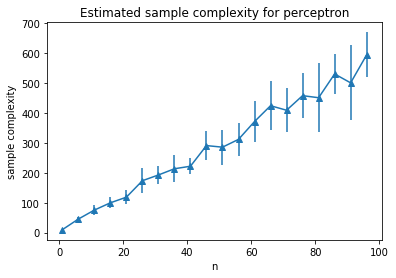

In [81]:
#Perceptron
sample_complexity_perceptron, iterations = estimate_sample_complexity(100,'perceptron',step_size=5,number_of_runs=10,number_of_samples=10)
plot_sample_complexity(sample_complexity_perceptron,step_size=5,function_choice='perceptron')

In [105]:
pd.DataFrame(sample_complexity_perceptron).to_pickle('sample_complexity_perceptron') 

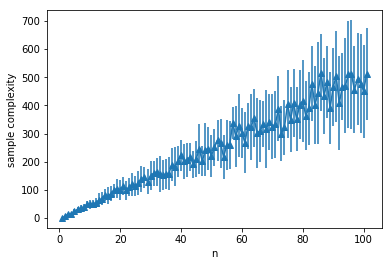

In [239]:
#OLD GRAPH PERCEPTRON
sample_complexity, iterations = estimate_sample_complexity(100,'perceptron',step_size=5,number_of_runs=20,number_of_samples=1)
plot_sample_complexity(sample_complexity)

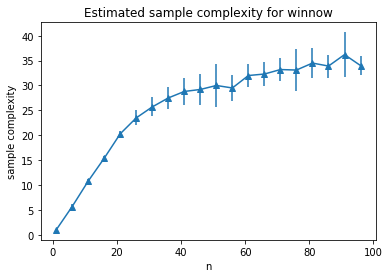

In [102]:
#Winnow
sample_complexity_winnow, iterations = estimate_sample_complexity(100,'winnow', step_size = 5, number_of_runs=10,number_of_samples=10) #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity_winnow,step_size=5,function_choice='winnow')

In [106]:
pd.DataFrame(sample_complexity_winnow).to_pickle('sample_complexity_winnow') 

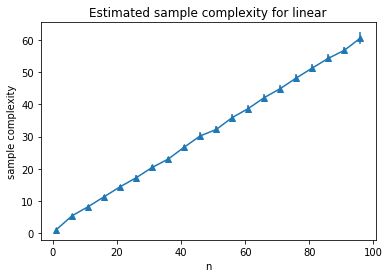

In [104]:
sample_complexity_linear, iterations = estimate_sample_complexity(100,'linear',step_size=5,number_of_runs=10,number_of_samples=10) #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity_linear,step_size=5,function_choice='linear')

In [107]:
pd.DataFrame(sample_complexity_linear).to_pickle('sample_complexity_linear') 

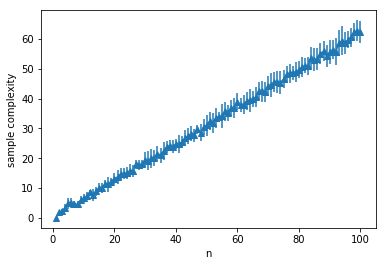

In [18]:
#OLD GRAPH LINEAR
sample_complexity_linear, iterations = estimate_sample_complexity(100,'linear',step_size=1,number_of_runs=20,number_of_samples=1) #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity_linear,step_size=5,function_choice='linear')

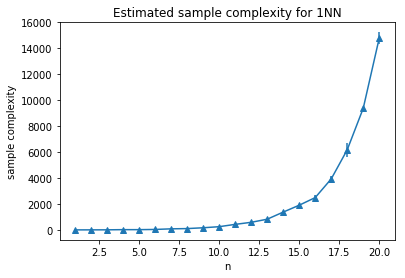

In [165]:
#1NN
sample_complexity_1nn, iterations = estimate_sample_complexity(20,'1nn',step_size=1,number_of_runs = 5,number_of_samples=5)
plot_sample_complexity(sample_complexity_1nn,step_size=1,function_choice='1NN')

In [166]:
pd.DataFrame(sample_complexity_1nn).to_pickle('sample_complexity_1nn') 

## Q1b) Discuss accuracy, computational time

### i) Procedure: 

Given a range of n, we estimate the sample complexity using Sampling and Binary Search algorithm. 

For each fixed n, we define the lower bound and upper bound of m values to consider, depending on the algorithm.

Binary search is then applied onto the interval of m values, to find minimum m that satisfies $\epsilon_{test}(m)<0.1$. 

$m_{left}$ is initialized to be the lower bound of m, $m_{right}$ is initialized to be the upper bound of m, and m_current is initialized to be n. 

To calculate $\epsilon_{test}(m)$ for each value of m, a training set of size (m,n), $S^{(i)}_{m}$ is randomly sampled from uniform distribution, and tested on a matrix of size(T,n). This step is repeated for 10 times. The mean test error calculated from 10 trials is used as a proxy to estimate the generalisation error $\epsilon(A_{S_m})$, at m. 

$ \hat{\epsilon}(A_{S_m}) = \frac{1}{10} \sum_{i=1}^{10} \frac{1}{T}\sum_{j=1}^{T}I[A_{S^{(i)}_m}(x_j)\neq y_j] $

The generalisation error is estimated this way at m_left, m_right, and m respectively. Compare these errors against each other and against our goal ($\epsilon=$0.1). For example, if $\hat{\epsilon}(A_{S_{left}}) <\hat{\epsilon}(A_{S_{right}})$, take the right half of this interval. This enables the algorithm to iteractively narrow down to the minimum value of training sample size that achives $\hat{\epsilon}(A_{S_m}) <0.1$.

The procedure above is repeated 10 times for a fixed n. So, applying Binary Search in the $i^{th}$ trial gives the $i^{th}$ estimate of sample complexity of n:

$C_n^{(i)}(A)$ = min $\{m\in \{1,2,..\}: \hat{\epsilon}(A_{S_m})\leq 0.1 \}$

Taking the average of $SC^{(i)}(n)$ across all 10 trials, the estimator of the sample complexity becomes: 

$\hat{C}_n(A) = \frac{1}{10} \sum_{i=1}^{10} C_n^{(i)}(A)$


### ii) Explaining the Bias and Trade-off
First, our estimator of $\epsilon(A_{S_m})$ fixing $m$ is unbiased, statistically speaking. 

The definition of generalization error is the difference between expected error on D and empirical error of the algorithm trained with training sets of size $m$.

Let $S^{(i)}_m$ be the training set generated at $i^{th}$ trial, indepdently from distribution D.

Let $L_i$ be the test error rate for the $i^{th}$ trial, $\frac{1}{T}\sum_{j=1}^{T}I[A_{S^{(i)}_m}(x_j)\neq y_j]$, where T pairs of test data, $[x_j, y_j]$ are generated indepdently to $S^{(i)}_m$. 

The expected value of $L_i$ across D is the generalisation error. 

$E(L_i) = \sum_{S_T \in \{-1,+1\}^n} \Big( \frac{1}{T}\sum_{j=1}^{T}I[A_{S^{(i)}_m}(x_j)\neq y_j]\Big) = \epsilon(A_{S_m}) $


The average test error rate $\overline{L}$ over $\alpha$ independent trials is used as an estimator of generalization error. According to the result above, $E(\overline{L})$ also gives generalization error with zero bias. As $\alpha$ increases, the union of all test samples has greater coverage of D, and the variance of $\overline{L}$ as an estimator decreases.  

$Var(\overline{L}) = \frac{1}{\alpha-1} Var(L_i)$

As $\alpha \rightarrow \infty$ we obtain an estmate of generalization error with increasing accuracy. But considering a trade-off between computational time and accuracy, $\alpha$ is set to be 10 for Perceptron, Winnow and Least Square, 5 for Nearest Neighbor. 

Similarly, $\hat{C}_n(A)$ is an unbiased estimator for sample complexity. We take the average across $r$ runs. Although increasing the number of runs leads to less variance in the estimation, the number of runs is set to be 10 for Perceptron, Winnow and Least Square, 5 for Nearest Neighbor. For details on computational times on sample complexity estimation, please refer to the section 'Computational time of sample complexity estimation' below.



### Explaning the choice of training set size
For example, T is set to be 10000 for all n in the test. But the total number of combinations of labels = $2^n$, meaning that the test set covers drastically less proportion of data points as n increases. The maximum proportion of input space represented by the test set   $\leq \frac{10000}{2^n}$, which is smaller than 1% when n=20. 

Similarly, the maximum proportion of input space represented by the training set $\leq \frac{m}{2^n}$, which is even smaller. 


### Explaining choosing the lower bound and upper bound of m
The Binary Algorithm is a faster method to look for C(A), than iterating increasing values of m. But since the algorithm looks for solution in a pre-defined range, it is important to ensure that the solution lies within this domain. These lower bound and upper bound of n are based on the trends observed on sample complexity for n={1,...,10}. The trend helps us to give a rough prediction on where C(A) could exist for n up to 100 by extrapolation. 


### Computational time of sample complexity estimation
Suppose we want to estimate the sample complexity up to n_max, take average of 10 test errors, and repeat this binary search for 10 runs, the total computational cost = $\sum_{n=1}^{n_max} B(n) \times 10$.  

$B(n)$ is the computational cost of running binary search with averaged test errors across 10 trials. 

Let the range of m considered in the binary search be R, $R = m_{left} - m_{right}$. R is dependent on n and function choice, let R = O(M(n)). 

For clarity, we first consider the computation cost per run, when both n and m are fixed. The maximum number of times we apply the function estimate_generalization_error is $O(log_2(M))$. Let the computational time of the chosen training algorithm to be $f_{train}(m,n)$, test algorithm to be $f_{test}(m,n)$. For a fix number of m, we train and test the algorithm for 10 trials to find the average test error. 

So the cost to estimate the generalization error for fixed m with 10 trials = $(f_{train}(m,n) + f_{test}(n)) \times 10 $

Since $R \sim O(M(n))$, and the number of m where the generalization error is computed = $O(log(M(n)))$

$B(n) \sim O \Big(log(M(n)) (f_{train}(M(n),n) + f_{test}(n)) \Big)$


Overall, the total computational time of estimating sample complexity for $n \in [n_{max}]$ is $Comp(n_{max})$:

$ Comp(n_{max})$ =  num_runs $\times \sum_{n=1}^{n_{max}} B(n) $

$\Rightarrow Comp(n_{max}) \sim O\Big(n_{max}B(n_{max}) \Big)$



#### Perceptron
$M(n) \sim  O(n)$

$f_{train}(m,n) \sim O(mn) \sim O(n^2)$

$f_{test}(n) \sim O(n \times T) \sim O(n) $ 

$B(n)  \sim O(log(n)) \times (O(n^2) +  O(n)) \sim O(n^2log(n))$

$\Rightarrow Comp(n_{max}) \sim O\Big(n_{max}B(n_{max}) \Big) \sim O\Big(n_{max}^3 log(n_{max})) \Big)$ 



#### Winnow
$M(n) \sim  O(n)$

Similarly as Perceptron, the computational cost is bounded below by: 

$\Rightarrow Comp(n_{max}) \sim O\Big(n_{max}B(n_{max}) \Big) \sim O\Big(n_{max}^3 log(n_{max})) \Big)$ 

In practice, Winnow runs slightly slower than Perceptron as it involves more vector multiplication. 



#### Linear Regression
$M(n) \sim  O(n)$

$f_{train}(m,n) \sim O(mn^2 + n^3) \sim O(n^3)$

$f_{test}(n) \sim O(n \times T) \sim O(n) $ 

$B(n)  \sim O(log(n)) \times (O(n^3) +  O(n)) \sim O(n^3log(n))$

$\Rightarrow Comp(n_{max}) \sim O\Big(n_{max}B(n_{max}) \Big) \sim O\Big(n_{max}^4 log(n_{max})) \Big)$ 



#### 1-NN
According to our current bounding on sample complexity, $M(n) \sim  O(n^3)$. 

1-NN involves calculation of pairwise distances between training and test data, hence the cost of applying it once:

$f(m,n) \sim O(mn\times T) \sim O(mn) \sim O(n^4)$

$B(n) \sim O(n^4 log(n^3)) $

$\Rightarrow Comp(n_{max}) \sim O\Big(n_{max}B(n_{max}) \Big) \sim O\Big(n_{max}^5 log(n_{max}^3)) \Big)$ 

Note that 1NN is the most costly algorithm to estimate sample complexity for. 

## Q1 c) Estimate m(n)

In [ ]:
#Still need to add O, and Omega. 

In [176]:
def fitting(sample_complexity, step_size,n_max,fitting_type='linear',function_type='Perceptron'):
    x_domain = np.arange(1,n_max,step_size)
    means = np.mean(sample_complexity, axis=1)
    means_crop = means[means>0]
    
    if fitting_type=='linear':
        m,b = polyfit(x_domain,means_crop,1)
        fit =  [b + m*x  for x in x_domain]
        print('estimated ϴ(m(n))=',round(b,2),'+ ',round(m,2),'n')
    
    elif fitting_type=='exponential':
        m,b = polyfit(x_domain,np.log(means_crop),1)
        fit =  [np.exp(b + m*x)  for x in x_domain]
        print('estimated ϴ(m(n))=',round(np.exp(b),2),'exp(',round(m,2),'n)')
      
    elif fitting_type=='log':
        m,b = polyfit(np.log(x_domain),means_crop,1)
        fit = [b + m*np.log(x)  for x in np.arange(1,100,step_size)]
        print('estimated ϴ(m(n))=',round(b,2),'+',round(m,2),'log(n)')
        
    plt.plot(x_domain,fit,color='r',label='fitted')
    plt.plot(x_domain,means_crop,color='b',label='actual')
    plt.title('Sample Complexity with ' + fitting_type +' fitting for '+ function_type)
    plt.ylabel('sample complexity')
    plt.xlabel('n')
    plt.show()

### Perceptron

estimated ϴ(m(n))= 5.79 +  5.84 n


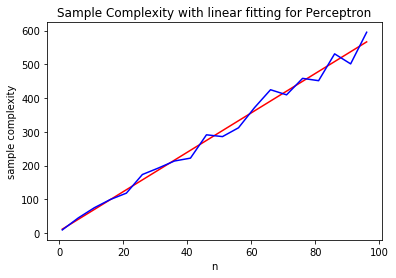

In [177]:
fitting(sample_complexity_perceptron, 5,100,fitting_type='linear')

### Winnow

estimated ϴ(m(n))= -5.15 + 8.78 log(n)


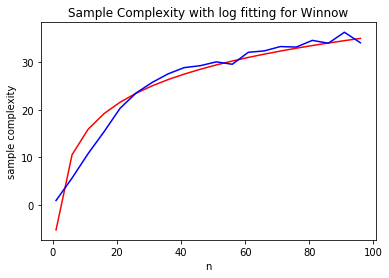

In [178]:
fitting(sample_complexity_winnow, 5,100,fitting_type='log',function_type='Winnow')

### Linear

estimated ϴ(m(n))= 1.25 +  0.62 n


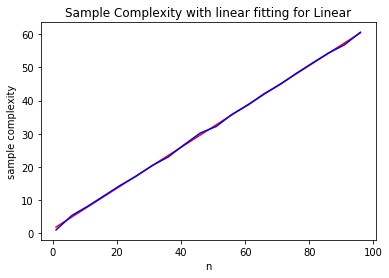

In [179]:
fitting(sample_complexity_linear, 5,100,fitting_type='linear',function_type='Linear')

### 1NN

estimated ϴ(m(n))= 5.49 exp( 0.08 n)


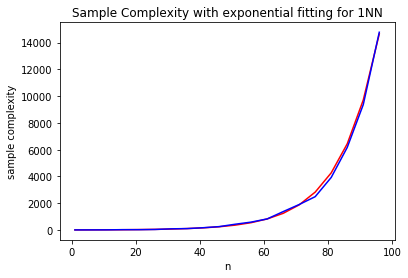

In [180]:
fitting(sample_complexity_1nn, 5,100,fitting_type='exponential',function_type='1NN')

## Discussion - explaining the observations

### Perceptron vs. Winnow

The sample complexity graphs indicate that Winnow is generally more accurate with larger number of irrelevant agents than Perceptron. This observation is consistent with the mistake bounds of online learning. 

Suppose there are k relevant agents, or literals, $k<<n$. 

Perceptron mistake bound = $(4k+1)(n+1) \sim O(kn)$

Winnow mistake bound = $3k(log(n)+1)+2 \sim O(klog(n))$

The upper bound of error rate for both algorithms  = $\frac{M}{m}$, where M is the mistake bound. 

This means that given fixed n, and that both Perceptron and Winnow are aiming for the same error rate $\epsilon$, Winnow requires less samples. More specifically, in order for the maximum error rate of either algorithm to be $< \epsilon \in (0,1)$: 

Perceptron: $m \geq \frac{(4k+1)(n+1)}{\epsilon} \sim \Omega(n)$

Winnow: $m \geq \frac{3k(log(n)+1)+2}{\epsilon} \sim \Omega(log(n))$



### Perceptron vs. Least Square

Given training set S, linear regression is directly derived by minimizing the empirical risk $\epsilon_{emp}(S,\omega)$ of the entire training dataset. Since the first agent, $x_0$ is always consistent with the label, the primal form of linear regression directly computes the optimal weight vector, where all the entires are close to zero except for the first one. The same weight will generalize well on the test data, because the test data is also sampled with its first agent consistent to label. 

On the other hand, Perceptron learns one example at a time by gradient descent with learning rate =1. This means that at each update, it could only increase the weight for the first agent by 1 at maximum. Also, since the learning rate is fixed at 1, Perceptron algorithm might 'overshoot'. 

Therefore, given the same $m$, linear regression achieves a smaller test error than perceptron in this particular case. 



### 1NN vs. all Linear Classifiers

Note that VC dimension of 1-Nearest-Neighbors is infinity, hence PAC cannot be applied to bound its sample complexity.

Unlike linear classifiers, 1NN predicts with the closest data point instead of finding a seperating hyperplane. It will not be able to identify the strongest predictors such as $x_0$, without any training process. As n increases, due to the curse of dimensionality, the euclidean distances from test point to its nearest point increases exponentially(?), and so the predictive power of nearest point will decay. It follows that $m$ have to grow exponentially keep a consistent accuracy. 

### Discussing Error Decomposition (not sure at all)
Given an Empirical Risk Minimizer, $h_{S} = ERM_{H}(S)$, the risk of $h_{S}$ can be decomposed the following way: 

$L_D(h_S) = \epsilon_{app} + \epsilon_{est}$

Perceptron, Winnow and Least Square have around the same complexity, as the VC dimension of their Hypothesis Space are n+1. Hence $\epsilon_{app}$ for three algorithms are expected to be similar. As n increases,$\epsilon_{app}$ increases. Is it similar to Bayes Error? 

1NN has very high complexity. In fact, the approximation error should be 0, because there exist a way to shatter all data points in $D$. 

# 1d) Upper bound of mistake probability for Perceptrons



The upper bound of total number of mistakes made by perceptron during training on any set of input = 
$M \leq (\frac{R}{\gamma})^2$

Let $S_m$ be a set of m training examples sampled independently from D. let t be drawn uniformly from {1,...,m}, where $P(t=t') = \frac{1}{m}$. 

Let $S_t \in S_m$ be the subset that consist of the first $t$ training examples that A has reviewed. 

The upper bound applies to the total number of mistakes made during training on $S_t$, $ \forall t \in [m]: M(t) \leq (\frac{R}{\gamma})^2$

Let $P(A_S(x_{t+1}) \neq y_{t+1})$ be the probability of mistake at the $(t+1) ^{th}$ trial, after the perceptron has been trained on $S_t$. Since $(x_{t+1},y_{t+1})$ is randomly sampled from D, therefore probability of making a mistake on the next trial, $P(A_S(x_{t+1}) \neq y_{t+1})$ is assumed to have the same upper bound $\forall t \in [m-1]$.

Hence using total proability and the upper bound of mistakes:

$\sum_{t'=0}^{m-1} P(A_S(x_{t'+1})!=y_{t'+1}) P(t=t') \leq (\frac{R}{\gamma})^2 $

Using the fact that the probability of misclassifying the next trial has the same upper bound and $P(t=t')=\frac{1}{m},$ $\forall t'\in [m]$

$P(A_S(x)!=y) \leq \frac{(\frac{R}{\gamma})^2}{m}$

In 'just a little bit' problem, we know that the maximum norm of $x$ from D is $\sqrt{n}$, giving $R = max(\parallel x \parallel_2) = \sqrt{n}$

$\Rightarrow P(A_S(x)!=y) \leq \frac{n}{m \gamma^2}$

# 1e)